Link to medium post: https://medium.com/@zhiwei_zhang/bitcoin-time-series-prediction-with-lstm-d3f49b1b4d00

In [11]:
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from math import sqrt

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

###  Load data by reading table from html

In [12]:
def get_market_data(market, tag=True):
    market_data = pd.read_html("https://coinmarketcap.com/currencies/" + market + 
                             "/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"), flavor='html5lib')[0]
    market_data = market_data.assign(Date=pd.to_datetime(market_data['Date']))  
    market_data['Volume'] = (pd.to_numeric(market_data['Volume'], errors='coerce').fillna(0))
    return market_data

btc_data = get_market_data("bitcoin", tag='BTC')
btc_data.head(10)

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-05-10,9325.96,9396.04,9040.52,9043.94,6.906700e+09,158772000000
1,2018-05-09,9223.73,9374.76,9031.62,9325.18,7.226890e+09,157013000000
2,2018-05-08,9380.87,9462.75,9127.77,9234.82,7.415870e+09,159672000000
3,2018-05-07,9645.67,9665.85,9231.53,9373.01,7.394020e+09,164161000000
4,2018-05-06,9845.31,9940.14,9465.25,9654.80,7.222280e+09,167541000000
5,2018-05-05,9700.28,9964.50,9695.12,9858.15,7.651940e+09,165055000000
6,2018-05-04,9695.50,9779.20,9585.96,9700.76,8.217830e+09,164956000000
7,2018-05-03,9233.97,9798.33,9188.15,9743.86,1.020730e+10,157087000000
8,2018-05-02,9104.60,9256.52,9015.14,9235.92,7.558160e+09,154869000000
9,2018-05-01,9251.47,9255.88,8891.05,9119.01,7.713020e+09,157350000000


In [4]:
# only keeps date and close price
data = btc_data[['Date']+['Close']]
data = data.sort_values(by='Date')
data.head()

,Date,Close
1838,2013-04-28,134.21
1837,2013-04-29,144.54
1836,2013-04-30,139.00
1835,2013-05-01,116.99
1834,2013-05-02,105.21


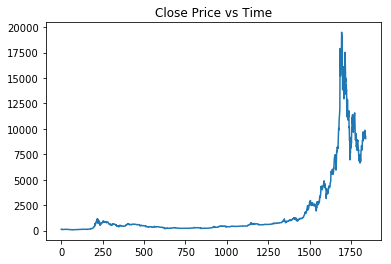

In [5]:
plt.plot(range(len(data['Close'])), data['Close'])
plt.title('Close Price vs Time')
plt.show()

In [6]:
# Normalize close price
from sklearn.preprocessing import MinMaxScaler
values = data['Close'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_price = scaler.fit_transform(values)
scaled_price

array([[0.00338567],
       [0.00391735],
       [0.0036322 ],
       ...,
       [0.4717898 ],
       [0.47644055],
       [0.4619653 ]], dtype=float32)

In [7]:
# split data for training, testing
train_size = int(len(scaled_price) * 0.7)
test_size = len(scaled_price) - train_size

train, test = scaled_price[0:train_size,:], scaled_price[train_size:len(scaled_price),:]
print(len(train), len(test))

1287 552


In [8]:
def create_input(data,lookback):
    inputs = []
    for i in range(len(data) - lookback):
        temp_set = data[i:(i + lookback),0].copy()
        inputs.append(temp_set)
    return np.array(inputs)

def create_output(data,lookback):
    output = []
    for i in range(len(data)-lookback):
        output.append(data[i + lookback, 0])
    return np.array(output)

# use lookback = 5
x_train = create_input(train,5)
x_test = create_input(test,5)

y_train = create_output(train,5)
y_test = create_output(test,5)

print('x_train shape', x_train.shape)
print('x_test shape', x_test.shape)

print('y_train shape', y_train.shape)
print('y_test shape', y_test.shape)


x_train shape (1282, 5)
x_test shape (547, 5)
y_train shape (1282,)
y_test shape (547,)


In [9]:
print("x_input:",x_train[0:4])
print("y:",y_train[0:3])

x_input: [[0.00338567 0.00391735 0.0036322  0.00249936 0.00189305]
 [0.00391735 0.0036322  0.00249936 0.00189305 0.00150909]
 [0.0036322  0.00249936 0.00189305 0.00150909 0.00226826]
 [0.00249936 0.00189305 0.00150909 0.00226826 0.00244377]]
y: [0.00150909 0.00226826 0.00244377]


In [10]:
x_train = np.reshape(x_train,(x_train.shape[0],1,x_train.shape[1]))
x_test = np.reshape(x_test,(x_test.shape[0],1,x_test.shape[1]))
print('x_train shape', x_train.shape)
print('x_test shape', x_test.shape)

x_train shape (1282, 1, 5)
x_test shape (547, 1, 5)


# Build Model

In [11]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout, Flatten,Conv2D, MaxPooling2D, Activation
from keras.layers.normalization import BatchNormalization
from keras import optimizers
import keras

model_1 = Sequential()
model_1.add(LSTM(100, input_shape=(1,x_train.shape[2])))
model_1.add(Dense(1))
model_1.compile(loss='mae', optimizer='adam')
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 42,501
Trainable params: 42,501
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model_1.fit(x_train, y_train, epochs=100, batch_size=128, 
                    validation_data=(x_test, y_test), verbose=1, shuffle=False)

Train on 1282 samples, validate on 547 samples
Epoch 1/100
1282/1282 [==============================] - 0s 214us/step - loss: 0.0085 - val_loss: 0.1989
Epoch 2/100
1282/1282 [==============================] - 0s 62us/step - loss: 0.0076 - val_loss: 0.1792
Epoch 3/100
1282/1282 [==============================] - 0s 60us/step - loss: 0.0068 - val_loss: 0.1576
Epoch 4/100
1282/1282 [==============================] - 0s 60us/step - loss: 0.0059 - val_loss: 0.1345
Epoch 5/100
1282/1282 [==============================] - 0s 58us/step - loss: 0.0053 - val_loss: 0.1125
Epoch 6/100
1282/1282 [==============================] - 0s 59us/step - loss: 0.0044 - val_loss: 0.0867
Epoch 7/100
1282/1282 [==============================] - 0s 63us/step - loss: 0.0037 - val_loss: 0.0621
Epoch 8/100
1282/1282 [==============================] - 0s 57us/step - loss: 0.0028 - val_loss: 0.0356
Epoch 9/100
1282/1282 [==============================] - 0s 54us/step - loss: 0.0021 - val_loss: 0.0205
Epoch 10/100
128

1282/1282 [==============================] - 0s 58us/step - loss: 9.2075e-04 - val_loss: 0.0175
Epoch 78/100
1282/1282 [==============================] - 0s 54us/step - loss: 0.0011 - val_loss: 0.0172
Epoch 79/100
1282/1282 [==============================] - 0s 54us/step - loss: 8.7826e-04 - val_loss: 0.0173
Epoch 80/100
1282/1282 [==============================] - 0s 58us/step - loss: 8.5038e-04 - val_loss: 0.0176
Epoch 81/100
1282/1282 [==============================] - 0s 57us/step - loss: 0.0011 - val_loss: 0.0173
Epoch 82/100
1282/1282 [==============================] - 0s 53us/step - loss: 9.5831e-04 - val_loss: 0.0172
Epoch 83/100
1282/1282 [==============================] - 0s 56us/step - loss: 7.9187e-04 - val_loss: 0.0173
Epoch 84/100
1282/1282 [==============================] - 0s 59us/step - loss: 0.0012 - val_loss: 0.0172
Epoch 85/100
1282/1282 [==============================] - 0s 58us/step - loss: 9.1169e-04 - val_loss: 0.0169
Epoch 86/100
1282/1282 [====================

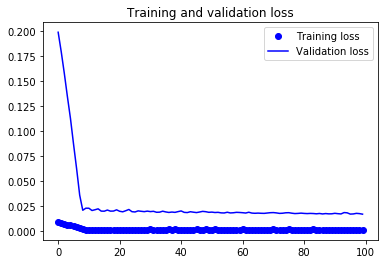

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

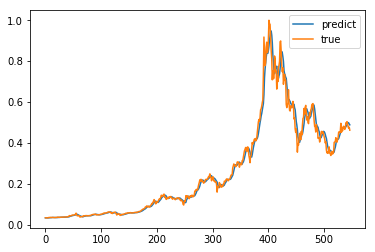

In [14]:
yhat = model_1.predict(x_test)
plt.plot(yhat, label='predict')
plt.plot(y_test, label='true')
plt.legend()
plt.show()

In [15]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 614.719


### Add a dropout layer

In [25]:
from keras import backend as K
K.clear_session()

In [50]:
model_2 = Sequential()
model_2.add(LSTM(100, input_shape=(1, x_train.shape[2])))
model_2.add(Dropout(0.2))
model_2.add(Dense(1))
model_2.compile(loss='mae', optimizer='adam')
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 42,501
Trainable params: 42,501
Non-trainable params: 0
_________________________________________________________________


In [51]:
model_2.compile(loss='mae', optimizer='adam')
history = model_2.fit(x_train, y_train, epochs=100, batch_size=128, 
                    validation_data=(x_test, y_test), verbose=1, shuffle=False)

Train on 1282 samples, validate on 547 samples
Epoch 1/100
1282/1282 [==============================] - 0s 328us/step - loss: 0.0088 - val_loss: 0.2086
Epoch 2/100
1282/1282 [==============================] - 0s 62us/step - loss: 0.0082 - val_loss: 0.1900
Epoch 3/100
1282/1282 [==============================] - 0s 61us/step - loss: 0.0071 - val_loss: 0.1664
Epoch 4/100
1282/1282 [==============================] - 0s 64us/step - loss: 0.0064 - val_loss: 0.1434
Epoch 5/100
1282/1282 [==============================] - 0s 59us/step - loss: 0.0055 - val_loss: 0.1199
Epoch 6/100
1282/1282 [==============================] - 0s 64us/step - loss: 0.0047 - val_loss: 0.0949
Epoch 7/100
1282/1282 [==============================] - 0s 64us/step - loss: 0.0039 - val_loss: 0.0682
Epoch 8/100
1282/1282 [==============================] - 0s 58us/step - loss: 0.0032 - val_loss: 0.0437
Epoch 9/100
1282/1282 [==============================] - 0s 58us/step - loss: 0.0022 - val_loss: 0.0227
Epoch 10/100
128

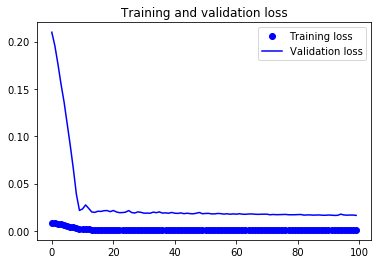

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

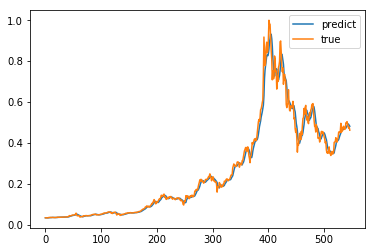

In [29]:
yhat = model_2.predict(x_test)
plt.plot(yhat, label='predict')
plt.plot(y_test, label='true')
plt.legend()
plt.show()

In [30]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 604.806
